2 (опция). Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Значение проверки качества на отложенной выборки на Out-of-Bag, будем выводитть вместе с построением леса. Поскольку в данном случае это характеристика конкретного леса построенного на конкретных данных

In [1]:
import matplotlib.pyplot as plt
import random
from sklearn import model_selection
from matplotlib.colors import ListedColormap
from sklearn import datasets
import pandas as pd
import numpy as np

Создадим функции необходимые для работы

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=3,flip_y = 0.08)

In [3]:
data = classification_data.copy()
labels = classification_labels.copy()

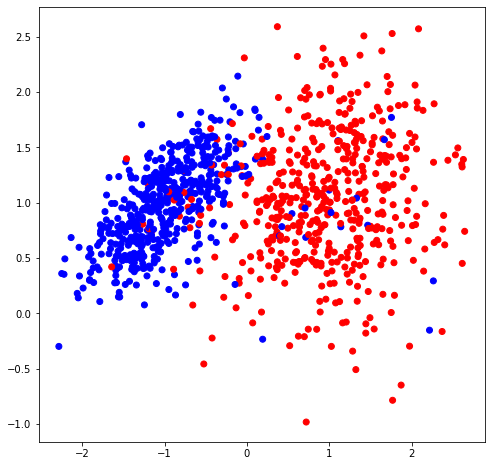

In [4]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1],
              classification_data)), 
              c=classification_labels, cmap=colors)

In [5]:
# Реализуем генерацию  𝑁  бутстрап-выборок и подмножества признаков для нахождения разбиения в узле
# а так же строки котрые не вошли в каждую выборку
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    out_index=[]
    for i in range(N):
        sample_index = np.random.randint(0,n_samples,n_samples-1)
        bootstrap.append((data[sample_index],labels[sample_index],)) 
        out_index.append(np.delete(np.arange(n_samples),sample_index))
    return bootstrap,out_index

In [6]:
# Реализуем случайный набор данных из выбранного признака. 
# По умолчанию будем брать уорень квадратный от общшего количества , но можно передать свою функцию расчета
def get_subsample(len_sample,fun='sqrt'):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    if fun=='sqrt':
        len_subsample = int(np.sqrt(len_sample))
    else:
        len_subsample = int(fun(len_sample))              
    return np.random.choice(sample_indexes,size = len_sample,replace = False)

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in set(self.labels):
            classes[label] = np.sum(self.labels==label)
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [9]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in set(labels):
        classes[label] = np.sum(labels==label)  
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [13]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [54]:
# Теперь добавим функцию формирования случайного леса.
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap,out_index = get_bootstrap(data, labels, n_trees) 
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
#   Расчитаем ошибку 
    predict_control = tree_vote_control(forest, data,out_index)
    labels = labels[predict_control!=None]
    predict_control = predict_control[predict_control!=None]
    accuracy = accuracy_metric(labels,predict_control)
    return forest,accuracy

In [15]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [16]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [17]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [76]:
# Для расчета предсказаний используются лиш те строки, 
# которые не участовавли в построении данного дерева
def tree_vote_control(forest, data,out_index):

    # добавим предсказания всех деревьев в список
    predictions =[]
    i=0
    for tree in forest:
        pred = predict(data[out_index[i]], tree)
        pred_lab = np.array([None]*len(data))
        pred_lab[out_index[i]] =pred
        predictions.append(pred_lab)
        i+=1

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = np.array([])
    for obj in predictions_per_object:
        obj = [z for z in obj if z!=None]
        if len(obj) != 0:
            voted_predictions = np.append(voted_predictions,max(set(obj), key=obj.count))
        else:
            voted_predictions = np.append(voted_predictions, None)      
    return voted_predictions

In [77]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [87]:
a = [1, 3, 10, 50, 100, 200]
for i in a:
    my_forest, accuracy = random_forest(data, labels, i)
    print (f'Out-of-Bag на {i} деревьях составляет {accuracy}')
    

Out-of-Bag на 1 деревьях составляет 90.633608815427
Out-of-Bag на 3 деревьях составляет 89.98682476943345
Out-of-Bag на 10 деревьях составляет 90.18218623481782
Out-of-Bag на 50 деревьях составляет 92.80000000000001
Out-of-Bag на 100 деревьях составляет 92.9
Out-of-Bag на 200 деревьях составляет 93.10000000000001
